# Project Setup

In [5]:
# =============================================================================
# CELL 1: PROJECT SETUP
# =============================================================================
# PURPOSE: Create folder structure for the project
# RUN: Once (first time only)
# =============================================================================

import os

folders = [
    "data/raw",
    "data/processed",
    "data/external",
    "notebooks",
    "src/data",
    "src/features",
    "src/models"
]

for folder in folders:
    os.makedirs(folder, exist_ok=True)
    print(f"Created: {folder}")

print("\n✓ Folder structure ready")

Created: data/raw
Created: data/processed
Created: data/external
Created: notebooks
Created: src/data
Created: src/features
Created: src/models

✓ Folder structure ready


# Imports

In [6]:
# =============================================================================
# CELL 2: IMPORTS
# =============================================================================
# PURPOSE: Load all required packages
# RUN: Every time you open the notebook
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import time
import os
import warnings

from nba_api.stats.endpoints import playergamelog, leaguedashteamstats
from nba_api.stats.static import players, teams as nba_teams

from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

print("✓ All packages loaded")

✓ All packages loaded


# Helper Functions

In [7]:
# =============================================================================
# CELL 3: HELPER FUNCTIONS
# =============================================================================
# PURPOSE: Core functions used throughout the project
# RUN: Every time you open the notebook
# =============================================================================

def get_player_id(player_name):
    """Convert player name to NBA.com player ID."""
    player_list = players.get_players()
    player = [p for p in player_list if p['full_name'].lower() == player_name.lower()]
    
    if not player:
        raise ValueError(f"Player '{player_name}' not found")
    
    return player[0]['id']


def search_player(partial_name):
    """Search for players by partial name."""
    player_list = players.get_players()
    matches = [p for p in player_list if partial_name.lower() in p['full_name'].lower()]
    
    for match in matches:
        print(f"  {match['full_name']}")
    
    return matches


def get_player_game_log(player_name, season='2025-26'):
    """Pull all games for a player in a given season."""
    player_id = get_player_id(player_name)
    
    log = playergamelog.PlayerGameLog(
        player_id=player_id,
        season=season,
        season_type_all_star='Regular Season'
    )
    
    df = log.get_data_frames()[0]
    df['PLAYER_NAME'] = player_name
    
    return df


def get_player_multi_season(player_name, seasons=['2024-25', '2025-26']):
    """Pull game logs across multiple seasons."""
    all_games = []
    
    for season in seasons:
        try:
            df = get_player_game_log(player_name, season)
            df['SEASON'] = season
            all_games.append(df)
            print(f"  {player_name} | {season}: {len(df)} games")
            time.sleep(0.5)
        except Exception as e:
            print(f"  {player_name} | {season}: Failed - {e}")
    
    if not all_games:
        return pd.DataFrame()
    
    return pd.concat(all_games, ignore_index=True)


def build_dataset(player_names, seasons=['2024-25', '2025-26']):
    """Build full dataset across multiple players and seasons."""
    all_data = []
    
    for i, player in enumerate(player_names):
        print(f"[{i+1}/{len(player_names)}] Pulling {player}...")
        
        df = get_player_multi_season(player, seasons)
        
        if not df.empty:
            all_data.append(df)
        
        time.sleep(1)
    
    full_df = pd.concat(all_data, ignore_index=True)
    print(f"\n{'='*40}")
    print(f"Total games collected: {len(full_df)}")
    print(f"Total players: {full_df['PLAYER_NAME'].nunique()}")
    
    return full_df


def get_player_latest_stats(player_id, df):
    """Get player's most recent stats from our dataset."""
    player_df = df[df['Player_ID'] == player_id].sort_values('GAME_DATE')
    
    if player_df.empty:
        return None
    
    latest = player_df.iloc[-1]
    
    return {
        'roll_pts_5': latest['ROLL_PTS_5'],
        'season_avg_pts': latest['SEASON_AVG_PTS'],
        'last_game_date': latest['GAME_DATE']
    }


def build_player_lookup(df):
    """Build player name → ID mapping."""
    player_ids = df['Player_ID'].unique()
    
    player_lookup = {}
    for pid in player_ids:
        player_list = players.get_players()
        player = [p for p in player_list if p['id'] == pid]
        if player:
            player_lookup[player[0]['full_name'].lower()] = pid
    
    return player_lookup


def get_team_abbreviation_map():
    """Create mapping from team name to abbreviation."""
    team_list = nba_teams.get_teams()
    return {team['full_name']: team['abbreviation'] for team in team_list}

print("✓ Helper functions defined")

✓ Helper functions defined


# Initial Data Collection (Phase 1)

In [ ]:
# =============================================================================
# CELL 4: INITIAL DATA COLLECTION
# =============================================================================
# PURPOSE: Pull game data for initial set of players
# RUN: Once (first time only) — Takes ~5-10 minutes
# SKIP: If you already have data/raw/player_game_logs.csv
# =============================================================================

# Initial 10 players
PLAYERS_INITIAL = [
    "Jayson Tatum",
    "Luka Dončić",
    "Shai Gilgeous-Alexander",
    "Giannis Antetokounmpo",
    "Joel Embiid",
    "Nikola Jokić",
    "Kevin Durant",
    "LeBron James",
    "Stephen Curry",
    "Anthony Edwards"
]

# Pull data
dataset = build_dataset(PLAYERS_INITIAL)

# Save raw data
dataset.to_csv("data/raw/player_game_logs.csv", index=False)
print("\n✓ Saved to data/raw/player_game_logs.csv")

[1/10] Pulling Jayson Tatum...
  Jayson Tatum | 2024-25: Failed - ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
  Jayson Tatum | 2025-26: Failed - ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
[2/10] Pulling Luka Dončić...


# Cell 5: Expand Player List (Phase 6)

In [ ]:
# =============================================================================
# CELL 5: EXPAND PLAYER LIST
# =============================================================================
# PURPOSE: Add more players to the dataset
# RUN: Once (after initial data collection) — Takes ~15-20 minutes
# SKIP: If you already have expanded data
# =============================================================================

# Load existing data
existing_df = pd.read_csv("data/raw/player_game_logs.csv")
existing_ids = existing_df['Player_ID'].unique().tolist()
print(f"Existing players: {len(existing_ids)}")

# Expanded list: 40 more players
PLAYERS_EXPANDED = [
    "Donovan Mitchell",
    "Devin Booker",
    "Kyrie Irving",
    "Damian Lillard",
    "Trae Young",
    "Zion Williamson",
    "De'Aaron Fox",
    "Ja Morant",
    "Tyrese Haliburton",
    "Paolo Banchero",
    "LaMelo Ball",
    "Jalen Brunson",
    "Domantas Sabonis",
    "Tyrese Maxey",
    "Scottie Barnes",
    "Cade Cunningham",
    "Desmond Bane",
    "CJ McCollum",
    "Brandon Ingram",
    "Zach LaVine",
    "Julius Randle",
    "Karl-Anthony Towns",
    "Bam Adebayo",
    "Pascal Siakam",
    "Mikal Bridges",
    "Dejounte Murray",
    "Fred VanVleet",
    "Anfernee Simons",
    "Jalen Williams",
    "Franz Wagner",
    "Tyler Herro",
    "Lauri Markkanen",
    "Jaren Jackson Jr.",
    "Anthony Davis",
    "Kawhi Leonard",
    "Paul George",
    "Jimmy Butler",
    "Khris Middleton",
    "Bradley Beal",
    "Derrick White",
    "RJ Barrett", 
    "Kristaps Porziņģis", 
    "Jaylen Brown"
]

# Pull new players only
new_data = build_dataset(PLAYERS_EXPANDED)

# Combine
if not new_data.empty:
    combined = pd.concat([existing_df, new_data], ignore_index=True)
    combined = combined.drop_duplicates(subset=['Player_ID', 'GAME_DATE', 'MATCHUP'])
    combined.to_csv("data/raw/player_game_logs.csv", index=False)
    print(f"\n✓ Combined dataset: {len(combined)} games")

Existing players: 10
[1/43] Pulling Donovan Mitchell...
  Donovan Mitchell | 2024-25: 71 games
  Donovan Mitchell | 2025-26: 51 games
[2/43] Pulling Devin Booker...
  Devin Booker | 2024-25: 75 games
  Devin Booker | 2025-26: 43 games
[3/43] Pulling Kyrie Irving...
  Kyrie Irving | 2024-25: 50 games
  Kyrie Irving | 2025-26: 0 games
[4/43] Pulling Damian Lillard...
  Damian Lillard | 2024-25: 58 games
  Damian Lillard | 2025-26: 0 games
[5/43] Pulling Trae Young...
  Trae Young | 2024-25: 76 games
  Trae Young | 2025-26: 10 games
[6/43] Pulling Zion Williamson...
  Zion Williamson | 2024-25: 30 games
  Zion Williamson | 2025-26: 40 games
[7/43] Pulling De'Aaron Fox...
  De'Aaron Fox | 2024-25: 62 games
  De'Aaron Fox | 2025-26: 45 games
[8/43] Pulling Ja Morant...
  Ja Morant | 2024-25: 50 games
  Ja Morant | 2025-26: 20 games
[9/43] Pulling Tyrese Haliburton...
  Tyrese Haliburton | 2024-25: 73 games
  Tyrese Haliburton | 2025-26: 0 games
[10/43] Pulling Paolo Banchero...
  Paolo Banc

# Cell 6: Load Raw Data

In [ ]:
# =============================================================================
# CELL 6: LOAD RAW DATA
# =============================================================================
# PURPOSE: Load the raw game data
# RUN: Every time after Cell 2-3
# =============================================================================

df_raw = pd.read_csv("data/raw/player_game_logs.csv")

print("=== RAW DATA LOADED ===")
print(f"Games: {len(df_raw)}")
print(f"Players: {df_raw['Player_ID'].nunique()}")
print(f"Columns: {df_raw.columns.tolist()}")

=== RAW DATA LOADED ===
Games: 4961
Players: 52
Columns: ['SEASON_ID', 'Player_ID', 'Game_ID', 'GAME_DATE', 'MATCHUP', 'WL', 'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'PLUS_MINUS', 'VIDEO_AVAILABLE', 'PLAYER_NAME', 'SEASON']


# Cell 7: Exploratory Data Analysis (Phase 2)

In [ ]:
# =============================================================================
# CELL 7: EXPLORATORY DATA ANALYSIS
# =============================================================================
# PURPOSE: Understand the data before modeling
# RUN: Optional — for exploration
# =============================================================================

print("=== POINTS DISTRIBUTION ===")
print(df_raw['PTS'].describe())

print("\n=== POINTS BY PLAYER ===")
print(df_raw.groupby('Player_ID')['PTS'].agg(['count', 'mean', 'std', 'min', 'max']).round(1))

print("\n=== MISSING VALUES ===")
print(df_raw.isnull().sum())

print("\n=== ZERO/LOW MINUTE GAMES ===")
print(f"Games with 0 minutes: {len(df_raw[df_raw['MIN'] == 0])}")
print(f"Games under 10 minutes: {len(df_raw[df_raw['MIN'] < 10])}")
print(f"Games under 15 minutes: {len(df_raw[df_raw['MIN'] < 15])}")

=== POINTS DISTRIBUTION ===
count    4961.000000
mean       22.643217
std         8.943849
min         0.000000
25%        16.000000
50%        22.000000
75%        29.000000
max        61.000000
Name: PTS, dtype: float64

=== POINTS BY PLAYER ===
           count  mean   std  min  max
Player_ID                             
2544         106  23.6   7.1    8   42
201142       112  26.2   6.7   11   43
201939       109  25.5  10.1    2   56
202331        68  16.1   7.3    2   35
202681        50  24.7   8.8    7   46
202695        78  24.9   8.3    6   55
203076        71  23.5  10.1    0   42
203078        59  16.1   7.8    0   30
203081        58  24.9   7.5    4   43
203114        73  11.1   5.7    0   23
203468       107  20.0   9.6    3   50
203507        97  29.6   7.7    2   59
203897       113  21.9   8.9    2   43
203944       125  20.3   6.9    5   41
203954        50  25.5   8.5    4   40
203999       109  29.3   9.4   10   61
204001        59  18.8   6.1    4   34
1626157    

# Cell 8: Visualize Points Distribution (Phase 2)

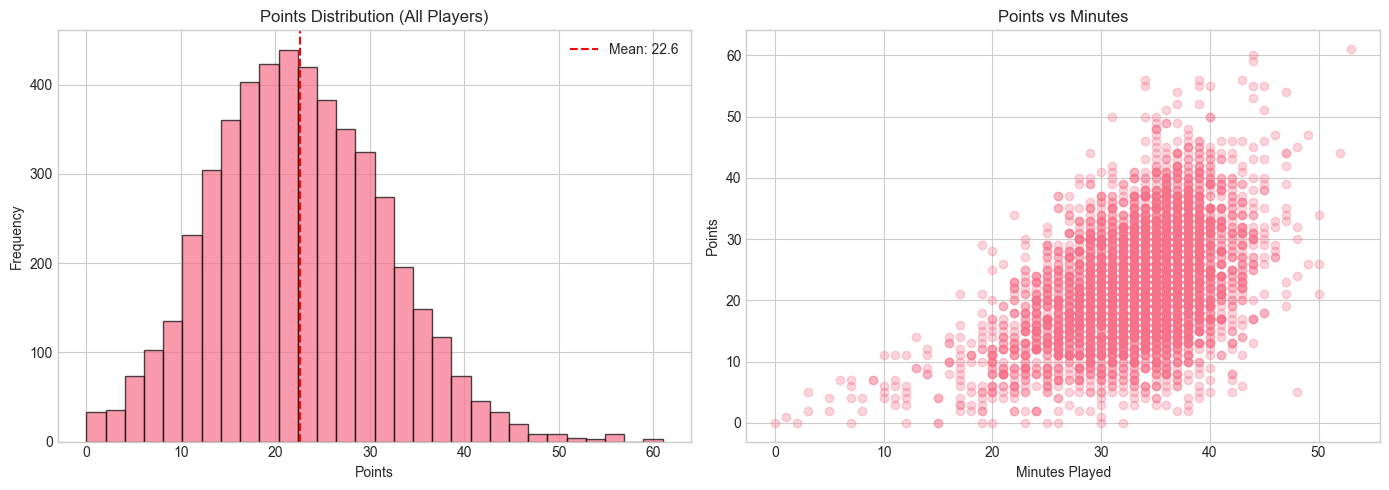

In [ ]:
# =============================================================================
# CELL 8: VISUALIZE POINTS DISTRIBUTION
# =============================================================================
# PURPOSE: Visual exploration of the data
# RUN: Optional — for exploration
# =============================================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Overall distribution
axes[0].hist(df_raw['PTS'], bins=30, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Points')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Points Distribution (All Players)')
axes[0].axvline(df_raw['PTS'].mean(), color='red', linestyle='--', label=f"Mean: {df_raw['PTS'].mean():.1f}")
axes[0].legend()

# By minutes
axes[1].scatter(df_raw['MIN'], df_raw['PTS'], alpha=0.3)
axes[1].set_xlabel('Minutes Played')
axes[1].set_ylabel('Points')
axes[1].set_title('Points vs Minutes')

plt.tight_layout()
plt.show()

# Cell 9: View Low Minute Games (Phase 2)

In [ ]:
# =============================================================================
# CELL 9: VIEW LOW MINUTE GAMES
# =============================================================================
# PURPOSE: Identify outlier games to remove
# RUN: Optional — for exploration
# =============================================================================

low_min = df_raw[df_raw['MIN'] < 15][['Player_ID', 'GAME_DATE', 'MATCHUP', 'MIN', 'PTS']]
print(f"=== LOW MINUTE GAMES ({len(low_min)} total) ===")
print(low_min.sort_values('MIN'))

=== LOW MINUTE GAMES (39 total) ===
      Player_ID     GAME_DATE      MATCHUP  MIN  PTS
3392    1628969  Apr 13, 2025    NYK @ BKN    0    0
2061    1627734  Mar 01, 2025    SAC @ HOU    1    1
4117    1628991  Mar 03, 2025  MEM vs. ATL    2    0
369      203507  Dec 03, 2025  MIL vs. DET    3    2
994     1630162  Oct 26, 2025  MIN vs. IND    3    5
3678    1629014  Nov 12, 2024  POR vs. MIN    5    2
2010    1628973  Jan 14, 2026    NYK @ SAC    5    4
1666    1629630  Nov 15, 2025    MEM @ CLE    6    7
4290     203076  Oct 29, 2025  DAL vs. IND    7    4
4246     203076  Dec 25, 2024    LAL @ GSW    7    0
3902    1630532  Dec 07, 2025    ORL @ NYK    7    7
1426    1629027  Oct 29, 2025    ATL @ BKN    7    6
3255    1628389  Nov 05, 2025    MIA @ DEN    8    2
3529    1627749  Jan 31, 2025  NOP vs. BOS    8    4
1237     202681  Mar 03, 2025  DAL vs. SAC    9    7
1856    1630163  Jan 27, 2025  CHA vs. LAL    9    7
2910     203944  Jan 30, 2025    MIN @ UTA   10    6
1854    16

# Cell 10: Data Cleaning (Phase 2)

In [ ]:
# =============================================================================
# CELL 10: DATA CLEANING
# =============================================================================
# PURPOSE: Remove outlier games
# RUN: Once (or when re-processing data)
# =============================================================================

print(f"Before cleaning: {len(df_raw)} games")

# Remove games under 15 minutes
df_clean = df_raw[df_raw['MIN'] >= 15].copy()

print(f"After cleaning: {len(df_clean)} games")
print(f"Removed: {len(df_raw) - len(df_clean)} games")

# Save
df_clean.to_csv("data/processed/player_game_logs_clean.csv", index=False)
print("\n✓ Saved to data/processed/player_game_logs_clean.csv")

Before cleaning: 4961 games
After cleaning: 4922 games
Removed: 39 games

✓ Saved to data/processed/player_game_logs_clean.csv


# Cell 11: Feature Engineering — Setup (Phase 3)

In [ ]:
# =============================================================================
# CELL 11: FEATURE ENGINEERING — SETUP
# =============================================================================
# PURPOSE: Prepare data for feature creation
# RUN: Once (or when re-processing data)
# =============================================================================

# Load clean data
df = pd.read_csv("data/processed/player_game_logs_clean.csv")

# Convert date and sort
df['GAME_DATE'] = pd.to_datetime(df['GAME_DATE'])
df = df.sort_values(['Player_ID', 'GAME_DATE']).reset_index(drop=True)

print(f"Loaded {len(df)} games")
print(f"Date range: {df['GAME_DATE'].min()} to {df['GAME_DATE'].max()}")

Loaded 4922 games
Date range: 2024-10-22 00:00:00 to 2026-02-12 00:00:00


# Cell 12: Feature Engineering — HOME/AWAY (Phase 3)

In [ ]:
# =============================================================================
# CELL 12: FEATURE ENGINEERING — HOME/AWAY
# =============================================================================
# PURPOSE: Create home/away feature
# RUN: Once (or when re-processing data)
# =============================================================================

# MATCHUP shows "BOS vs. MIA" (home) or "BOS @ MIA" (away)
df['HOME'] = df['MATCHUP'].apply(lambda x: 1 if 'vs.' in x else 0)

print("=== HOME/AWAY FEATURE ===")
print(df['HOME'].value_counts())
print(f"\nHome points avg: {df[df['HOME'] == 1]['PTS'].mean():.1f}")
print(f"Away points avg: {df[df['HOME'] == 0]['PTS'].mean():.1f}")

=== HOME/AWAY FEATURE ===
HOME
1    2484
0    2438
Name: count, dtype: int64

Home points avg: 22.7
Away points avg: 22.8


# Cell 13: Feature Engineering — REST DAYS (Phase 3)

In [ ]:
# =============================================================================
# CELL 13: FEATURE ENGINEERING — REST DAYS
# =============================================================================
# PURPOSE: Create rest days and back-to-back features
# RUN: Once (or when re-processing data)
# =============================================================================

# Calculate days since last game per player
for pid in df['Player_ID'].unique():
    mask = df['Player_ID'] == pid
    df.loc[mask, 'REST_DAYS'] = df.loc[mask, 'GAME_DATE'].diff().dt.days

# Fill NaN (first game) with 7, cap at 7
df['REST_DAYS'] = df['REST_DAYS'].fillna(7).clip(upper=7)

# Back-to-back flag (played yesterday)
df['B2B'] = (df['REST_DAYS'] == 1).astype(int)

print("=== REST DAYS FEATURE ===")
print(df['REST_DAYS'].value_counts().sort_index())
print(f"\nBack-to-back games: {df['B2B'].sum()}")
print(f"B2B points avg: {df[df['B2B'] == 1]['PTS'].mean():.1f}")
print(f"Non-B2B points avg: {df[df['B2B'] == 0]['PTS'].mean():.1f}")

=== REST DAYS FEATURE ===
REST_DAYS
1.0     720
2.0    2808
3.0     745
4.0     244
5.0      81
6.0      47
7.0     277
Name: count, dtype: int64

Back-to-back games: 720
B2B points avg: 23.3
Non-B2B points avg: 22.7


# Cell 14: Feature Engineering — ROLLING AVERAGES (Phase 3)

In [ ]:
# =============================================================================
# CELL 14: FEATURE ENGINEERING — ROLLING AVERAGES
# =============================================================================
# PURPOSE: Create rolling average features (recent form)
# RUN: Once (or when re-processing data)
# =============================================================================

# shift(1) ensures we only use PAST games (no data leakage)
for pid in df['Player_ID'].unique():
    mask = df['Player_ID'] == pid
    pts_shifted = df.loc[mask, 'PTS'].shift(1)
    
    df.loc[mask, 'ROLL_PTS_3'] = pts_shifted.rolling(window=3, min_periods=1).mean()
    df.loc[mask, 'ROLL_PTS_5'] = pts_shifted.rolling(window=5, min_periods=1).mean()
    df.loc[mask, 'ROLL_PTS_10'] = pts_shifted.rolling(window=10, min_periods=1).mean()

print("=== ROLLING AVERAGES (sample) ===")
sample_pid = df['Player_ID'].iloc[0]
print(df[df['Player_ID'] == sample_pid][['GAME_DATE', 'PTS', 'ROLL_PTS_3', 'ROLL_PTS_5', 'ROLL_PTS_10']].head(10))

=== ROLLING AVERAGES (sample) ===
   GAME_DATE  PTS  ROLL_PTS_3  ROLL_PTS_5  ROLL_PTS_10
0 2024-10-22   16         NaN         NaN          NaN
1 2024-10-25   21   16.000000        16.0    16.000000
2 2024-10-26   32   18.500000        18.5    18.500000
3 2024-10-28   11   23.000000        23.0    23.000000
4 2024-10-30   26   21.333333        20.0    20.000000
5 2024-11-01   27   23.000000        21.2    21.200000
6 2024-11-04   20   21.333333        23.4    22.166667
7 2024-11-06   39   24.333333        23.2    21.857143
8 2024-11-08   21   28.666667        24.6    24.000000
9 2024-11-10   19   26.666667        26.6    23.666667


# Cell 15: Feature Engineering — SEASON AVERAGE (Phase 3)

In [ ]:
# =============================================================================
# CELL 15: FEATURE ENGINEERING — SEASON AVERAGE
# =============================================================================
# PURPOSE: Create season average feature (player baseline)
# RUN: Once (or when re-processing data)
# =============================================================================

# Calculate expanding season average per player per season
for pid in df['Player_ID'].unique():
    for season in df['SEASON'].unique():
        mask = (df['Player_ID'] == pid) & (df['SEASON'] == season)
        if mask.sum() > 0:
            pts_shifted = df.loc[mask, 'PTS'].shift(1)
            df.loc[mask, 'SEASON_AVG_PTS'] = pts_shifted.expanding(min_periods=1).mean()

# Fill NaN (first game of season) with player overall average
player_avgs = df.groupby('Player_ID')['PTS'].mean()
for pid in df['Player_ID'].unique():
    mask = (df['Player_ID'] == pid) & (df['SEASON_AVG_PTS'].isna())
    if mask.sum() > 0:
        df.loc[mask, 'SEASON_AVG_PTS'] = player_avgs[pid]

# Fill remaining NaN in rolling averages
df['ROLL_PTS_3'] = df['ROLL_PTS_3'].fillna(df['SEASON_AVG_PTS'])
df['ROLL_PTS_5'] = df['ROLL_PTS_5'].fillna(df['SEASON_AVG_PTS'])
df['ROLL_PTS_10'] = df['ROLL_PTS_10'].fillna(df['SEASON_AVG_PTS'])

print("=== SEASON AVERAGES ===")
print(df.groupby('Player_ID')['SEASON_AVG_PTS'].mean().round(1))

=== SEASON AVERAGES ===
Player_ID
2544       22.4
201142     26.4
201939     24.7
202331     15.8
202681     23.9
202695     21.8
203076     26.9
203078     16.9
203081     25.6
203114     11.4
203468     19.4
203507     31.5
203897     22.9
203944     21.5
203954     21.9
203999     29.0
204001     19.5
1626157    22.9
1626164    25.7
1627734    19.5
1627742    22.2
1627749    16.0
1627759    25.9
1627783    21.8
1627832    14.7
1628368    23.8
1628369    28.2
1628374    23.7
1628378    26.4
1628389    17.4
1628401    17.3
1628969    16.9
1628973    26.7
1628983    31.7
1628991    20.6
1629014    16.8
1629027    23.4
1629029    31.2
1629627    22.5
1629628    21.7
1629630    21.3
1629639    23.5
1630162    28.2
1630163    24.8
1630169    17.3
1630178    29.0
1630217    17.8
1630532    23.8
1630567    19.7
1630595    25.2
1631094    23.4
1631114    19.7
Name: SEASON_AVG_PTS, dtype: float64


# Cell 16: Feature Engineering — OPPONENT (Phase 3)

In [ ]:
# =============================================================================
# CELL 16: FEATURE ENGINEERING — OPPONENT
# =============================================================================
# PURPOSE: Extract opponent team from matchup
# RUN: Once (or when re-processing data)
# =============================================================================

def extract_opponent(matchup):
    if ' vs. ' in matchup:
        return matchup.split(' vs. ')[1]
    elif ' @ ' in matchup:
        return matchup.split(' @ ')[1]
    return None

df['OPPONENT'] = df['MATCHUP'].apply(extract_opponent)

print("=== OPPONENTS ===")
print(df['OPPONENT'].value_counts().head(10))

=== OPPONENTS ===
OPPONENT
ATL    180
ORL    176
BKN    176
CHI    175
WAS    172
TOR    171
SAS    171
MIA    169
MEM    167
DAL    167
Name: count, dtype: int64


# Cell 17: Pull Team Defensive Ratings (Phase 3)

In [ ]:
# =============================================================================
# CELL 17: PULL TEAM DEFENSIVE RATINGS
# =============================================================================
# PURPOSE: Get opponent defensive strength
# RUN: Once (or when updating team ratings)
# =============================================================================

team_abbrev_map = get_team_abbreviation_map()

def get_team_defensive_proxy(season):
    """Create defensive strength proxy using PLUS_MINUS."""
    try:
        stats = leaguedashteamstats.LeagueDashTeamStats(
            season=season,
            per_mode_detailed='PerGame'
        )
        df_stats = stats.get_data_frames()[0]
        
        df_stats['TEAM_ABBREVIATION'] = df_stats['TEAM_NAME'].map(team_abbrev_map)
        df_stats['OPP_DEF_RATING'] = -df_stats['PLUS_MINUS']
        df_stats['SEASON'] = season
        
        return df_stats[['TEAM_ABBREVIATION', 'OPP_DEF_RATING', 'SEASON']]
    except Exception as e:
        print(f"{season} failed: {e}")
        return None

# Pull for all seasons
seasons = ['2022-23', '2023-24', '2024-25']
all_ratings = []

for season in seasons:
    print(f"Pulling {season}...")
    ratings = get_team_defensive_proxy(season)
    if ratings is not None:
        all_ratings.append(ratings)
        print(f"  Got {len(ratings)} teams")
    time.sleep(1)

team_ratings = pd.concat(all_ratings, ignore_index=True)

# Save
team_ratings.to_csv('data/external/team_defensive_ratings.csv', index=False)
print("\n✓ Saved to data/external/team_defensive_ratings.csv")

print("\n=== TEAM DEFENSIVE RATINGS ===")
print(team_ratings.sort_values('OPP_DEF_RATING', ascending=False).head(10))

Pulling 2022-23...
  Got 30 teams
Pulling 2023-24...
  Got 30 teams
Pulling 2024-25...
  Got 30 teams

✓ Saved to data/external/team_defensive_ratings.csv

=== TEAM DEFENSIVE RATINGS ===
   TEAM_ABBREVIATION  OPP_DEF_RATING   SEASON
89               WAS            12.4  2024-25
33               CHA            10.2  2023-24
26               SAS            10.0  2022-23
78               NOP             9.4  2024-25
88               UTA             9.3  2024-25
59               WAS             9.3  2023-24
63               CHA             9.1  2024-25
38               DET             9.1  2023-24
54               POR             9.0  2023-24
8                DET             8.2  2022-23


# Cell 18: Feature Engineering — OPP_DEF_RATING (Phase 3)

In [ ]:
# =============================================================================
# CELL 18: FEATURE ENGINEERING — OPP_DEF_RATING
# =============================================================================
# PURPOSE: Add opponent defensive rating to each game
# RUN: Once (or when re-processing data)
# =============================================================================

# Load team ratings
team_ratings_df = pd.read_csv('data/external/team_defensive_ratings.csv')

# Create mapping
def_rating_map = team_ratings_df.set_index(['TEAM_ABBREVIATION', 'SEASON'])['OPP_DEF_RATING'].to_dict()

# Apply to dataframe
df['OPP_DEF_RATING'] = df.apply(
    lambda row: def_rating_map.get((row['OPPONENT'], row['SEASON']), 0),
    axis=1
)

print("=== OPPONENT DEFENSIVE RATING ===")
print(f"Games with rating: {df['OPP_DEF_RATING'].notna().sum()}")
print(f"Rating range: {df['OPP_DEF_RATING'].min():.1f} to {df['OPP_DEF_RATING'].max():.1f}")

=== OPPONENT DEFENSIVE RATING ===
Games with rating: 4922
Rating range: -12.9 to 12.4


# Cell 19: Verify All Features (Phase 3)

In [ ]:
# =============================================================================
# CELL 19: VERIFY ALL FEATURES
# =============================================================================
# PURPOSE: Check all features are created correctly
# RUN: Once (or when re-processing data)
# =============================================================================

feature_cols = ['HOME', 'REST_DAYS', 'B2B', 'ROLL_PTS_3', 'ROLL_PTS_5', 'ROLL_PTS_10', 'SEASON_AVG_PTS', 'OPP_DEF_RATING']

print("=== FEATURE SUMMARY ===")
print(df[feature_cols].describe().round(2))

print("\n=== MISSING VALUES ===")
print(df[feature_cols].isnull().sum())

print("\n=== SAMPLE ROW ===")
print(df[['Player_ID', 'GAME_DATE', 'PTS'] + feature_cols].iloc[50])

=== FEATURE SUMMARY ===
         HOME  REST_DAYS      B2B  ROLL_PTS_3  ROLL_PTS_5  ROLL_PTS_10  \
count  4922.0    4922.00  4922.00     4922.00     4922.00      4922.00   
mean      0.5       2.47     0.15       22.79       22.80        22.81   
std       0.5       1.41     0.35        6.36        5.73         5.20   
min       0.0       1.00     0.00        5.00        5.80         7.00   
25%       0.0       2.00     0.00       18.33       18.80        19.10   
50%       1.0       2.00     0.00       22.33       22.60        22.70   
75%       1.0       3.00     0.00       27.00       26.60        26.50   
max       1.0       7.00     1.00       46.00       44.00        38.40   

       SEASON_AVG_PTS  OPP_DEF_RATING  
count         4922.00         4922.00  
mean            22.80            0.18  
std              5.07            4.60  
min              4.00          -12.90  
25%             19.11           -1.20  
50%             22.79            0.00  
75%             26.04        

# Cell 20: Save Featured Data (Phase 3)

In [ ]:
# =============================================================================
# CELL 20: SAVE FEATURED DATA
# =============================================================================
# PURPOSE: Save the complete featured dataset
# RUN: Once (or when re-processing data)
# =============================================================================

df.to_csv("data/processed/player_game_logs_featured.csv", index=False)
print(f"✓ Saved to data/processed/player_game_logs_featured.csv")
print(f"  Total games: {len(df)}")
print(f"  Total players: {df['Player_ID'].nunique()}")

✓ Saved to data/processed/player_game_logs_featured.csv
  Total games: 4922
  Total players: 52


# Cell 21: Load Featured Data for Modeling (Phase 4)

In [ ]:
# =============================================================================
# CELL 21: LOAD FEATURED DATA FOR MODELING
# =============================================================================
# PURPOSE: Load the featured dataset for model training
# RUN: When training/evaluating models
# =============================================================================

df = pd.read_csv("data/processed/player_game_logs_featured.csv")
df['GAME_DATE'] = pd.to_datetime(df['GAME_DATE'])

print(f"Loaded {len(df)} games")
print(f"Players: {df['Player_ID'].nunique()}")
print(f"Columns: {df.columns.tolist()}")

Loaded 4922 games
Players: 52
Columns: ['SEASON_ID', 'Player_ID', 'Game_ID', 'GAME_DATE', 'MATCHUP', 'WL', 'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'PLUS_MINUS', 'VIDEO_AVAILABLE', 'PLAYER_NAME', 'SEASON', 'HOME', 'REST_DAYS', 'B2B', 'ROLL_PTS_3', 'ROLL_PTS_5', 'ROLL_PTS_10', 'SEASON_AVG_PTS', 'OPPONENT', 'OPP_DEF_RATING']


# Cell 22: Define Features and Target (Phase 4)

In [ ]:
# =============================================================================
# CELL 22: DEFINE FEATURES AND TARGET
# =============================================================================
# PURPOSE: Set up X (features) and y (target) for modeling
# RUN: When training/evaluating models
# =============================================================================

# Feature columns
feature_cols = [
    'HOME',
    'REST_DAYS',
    'B2B',
    'ROLL_PTS_5',
    'SEASON_AVG_PTS',
    'OPP_DEF_RATING'
]

# Target column
target_col = 'PTS'

# Sort by date for time-based split
df = df.sort_values('GAME_DATE').reset_index(drop=True)

# Create X and y
X = df[feature_cols]
y = df[target_col]

print(f"Features: {feature_cols}")
print(f"Target: {target_col}")
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

Features: ['HOME', 'REST_DAYS', 'B2B', 'ROLL_PTS_5', 'SEASON_AVG_PTS', 'OPP_DEF_RATING']
Target: PTS
X shape: (4922, 6)
y shape: (4922,)


# Cell 23: Train/Test Split (Phase 4)

In [ ]:
# =============================================================================
# CELL 23: TRAIN/TEST SPLIT
# =============================================================================
# PURPOSE: Split data chronologically (train on past, test on future)
# RUN: When training/evaluating models
# =============================================================================

# Use last 20% as test set (most recent games)
split_index = int(len(df) * 0.8)

X_train = X.iloc[:split_index]
X_test = X.iloc[split_index:]
y_train = y.iloc[:split_index]
y_test = y.iloc[split_index:]

print(f"Training set: {len(X_train)} games")
print(f"Test set: {len(X_test)} games")
print(f"\nTraining period: {df['GAME_DATE'].iloc[0].strftime('%Y-%m-%d')} to {df['GAME_DATE'].iloc[split_index-1].strftime('%Y-%m-%d')}")
print(f"Test period: {df['GAME_DATE'].iloc[split_index].strftime('%Y-%m-%d')} to {df['GAME_DATE'].iloc[-1].strftime('%Y-%m-%d')}")

Training set: 3937 games
Test set: 985 games

Training period: 2024-10-22 to 2025-12-12
Test period: 2025-12-12 to 2026-02-12


# Cell 24: Train Baseline Model — Linear Regression (Phase 4)

In [ ]:
# =============================================================================
# CELL 24: TRAIN BASELINE MODEL — LINEAR REGRESSION
# =============================================================================
# PURPOSE: Establish a baseline with the simplest model
# RUN: When training/evaluating models
# =============================================================================

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

y_pred_lr = lr_model.predict(X_test)

mae_lr = mean_absolute_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr = r2_score(y_test, y_pred_lr)

print("=== LINEAR REGRESSION RESULTS ===")
print(f"MAE:  {mae_lr:.2f} points")
print(f"RMSE: {rmse_lr:.2f} points")
print(f"R²:   {r2_lr:.3f}")

=== LINEAR REGRESSION RESULTS ===
MAE:  5.89 points
RMSE: 7.48 points
R²:   0.260


# Cell 25: Train Ridge Regression (Phase 4)

In [ ]:
# =============================================================================
# CELL 25: TRAIN RIDGE REGRESSION
# =============================================================================
# PURPOSE: Linear regression with regularization
# RUN: When training/evaluating models
# =============================================================================

ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train, y_train)

y_pred_ridge = ridge_model.predict(X_test)

mae_ridge = mean_absolute_error(y_test, y_pred_ridge)
rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
r2_ridge = r2_score(y_test, y_pred_ridge)

print("=== RIDGE REGRESSION RESULTS ===")
print(f"MAE:  {mae_ridge:.2f} points")
print(f"RMSE: {rmse_ridge:.2f} points")
print(f"R²:   {r2_ridge:.3f}")

=== RIDGE REGRESSION RESULTS ===
MAE:  5.89 points
RMSE: 7.48 points
R²:   0.260


# Cell 26: Train Random Forest (Phase 4)

In [ ]:
# =============================================================================
# CELL 26: TRAIN RANDOM FOREST
# =============================================================================
# PURPOSE: Capture non-linear patterns
# RUN: When training/evaluating models
# =============================================================================

rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print("=== RANDOM FOREST RESULTS ===")
print(f"MAE:  {mae_rf:.2f} points")
print(f"RMSE: {rmse_rf:.2f} points")
print(f"R²:   {r2_rf:.3f}")

=== RANDOM FOREST RESULTS ===
MAE:  5.96 points
RMSE: 7.55 points
R²:   0.247


# Cell 27: Train Gradient Boosting (Phase 4)

In [ ]:
# =============================================================================
# CELL 27: TRAIN GRADIENT BOOSTING
# =============================================================================
# PURPOSE: Often best for tabular data
# RUN: When training/evaluating models
# =============================================================================

gb_model = GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=42)
gb_model.fit(X_train, y_train)

y_pred_gb = gb_model.predict(X_test)

mae_gb = mean_absolute_error(y_test, y_pred_gb)
rmse_gb = np.sqrt(mean_squared_error(y_test, y_pred_gb))
r2_gb = r2_score(y_test, y_pred_gb)

print("=== GRADIENT BOOSTING RESULTS ===")
print(f"MAE:  {mae_gb:.2f} points")
print(f"RMSE: {rmse_gb:.2f} points")
print(f"R²:   {r2_gb:.3f}")

=== GRADIENT BOOSTING RESULTS ===
MAE:  5.90 points
RMSE: 7.51 points
R²:   0.255


# Cell 28: Compare All Models (Phase 4)

In [ ]:
# =============================================================================
# CELL 28: COMPARE ALL MODELS
# =============================================================================
# PURPOSE: Find the best performing model
# RUN: When training/evaluating models
# =============================================================================

results = pd.DataFrame({
    'Model': ['Linear Regression', 'Ridge', 'Random Forest', 'Gradient Boosting'],
    'MAE': [mae_lr, mae_ridge, mae_rf, mae_gb],
    'RMSE': [rmse_lr, rmse_ridge, rmse_rf, rmse_gb],
    'R²': [r2_lr, r2_ridge, r2_rf, r2_gb]
}).sort_values('MAE')

print("=== MODEL COMPARISON ===")
print(results.to_string(index=False))
print(f"\n✓ Best model: {results.iloc[0]['Model']} (MAE: {results.iloc[0]['MAE']:.2f})")

=== MODEL COMPARISON ===
            Model      MAE     RMSE       R²
            Ridge 5.889280 7.482698 0.260069
Linear Regression 5.889283 7.482694 0.260069
Gradient Boosting 5.902873 7.508599 0.254937
    Random Forest 5.957894 7.547423 0.247213

✓ Best model: Ridge (MAE: 5.89)


# Cell 29: Feature Importance (Phase 4)

In [ ]:
# =============================================================================
# CELL 29: FEATURE IMPORTANCE
# =============================================================================
# PURPOSE: Understand which features matter most
# RUN: When training/evaluating models
# =============================================================================

# Ridge coefficients
coefficients = pd.DataFrame({
    'Feature': feature_cols,
    'Coefficient': ridge_model.coef_
}).sort_values('Coefficient', key=abs, ascending=False)

print("=== FEATURE IMPORTANCE (Ridge) ===")
print(coefficients)
print(f"\nIntercept: {ridge_model.intercept_:.2f}")

=== FEATURE IMPORTANCE (Ridge) ===
          Feature  Coefficient
4  SEASON_AVG_PTS     0.638741
1       REST_DAYS    -0.396853
2             B2B    -0.301557
3      ROLL_PTS_5     0.132639
0            HOME     0.090620
5  OPP_DEF_RATING     0.068198

Intercept: 6.28


# Cell 30: Visualize Predictions (Phase 4)

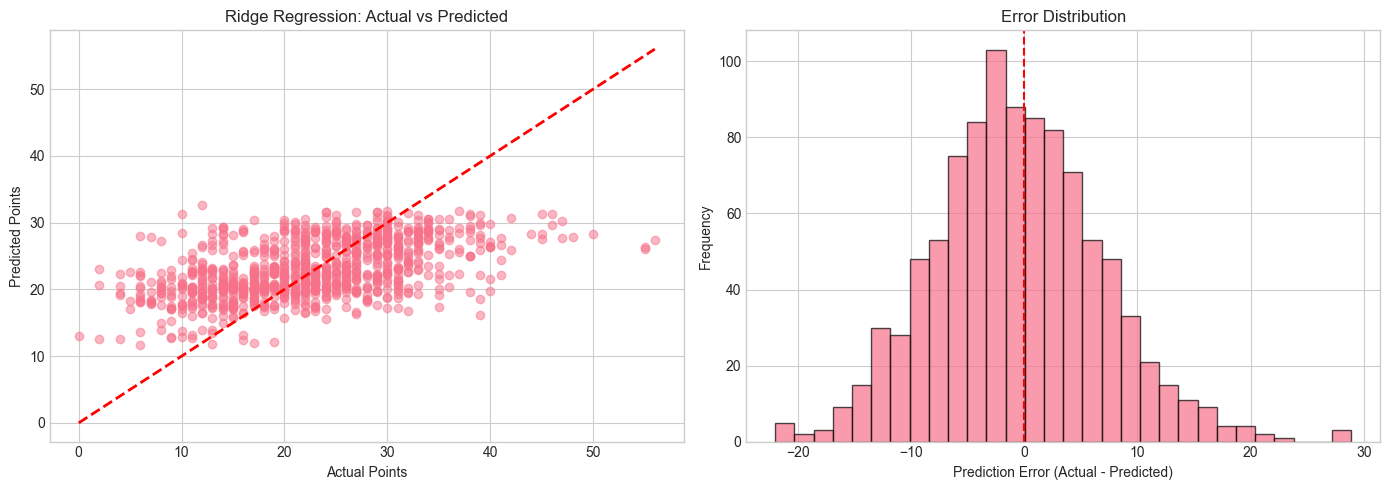

Mean Error: -0.61
Error Std: 7.46


In [ ]:
# =============================================================================
# CELL 30: VISUALIZE PREDICTIONS
# =============================================================================
# PURPOSE: Visual check of model performance
# RUN: When training/evaluating models
# =============================================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scatter plot: Actual vs Predicted
axes[0].scatter(y_test, y_pred_ridge, alpha=0.5)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual Points')
axes[0].set_ylabel('Predicted Points')
axes[0].set_title('Ridge Regression: Actual vs Predicted')

# Error distribution
errors = y_test - y_pred_ridge
axes[1].hist(errors, bins=30, edgecolor='black', alpha=0.7)
axes[1].axvline(x=0, color='red', linestyle='--')
axes[1].set_xlabel('Prediction Error (Actual - Predicted)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Error Distribution')

plt.tight_layout()
plt.show()

print(f"Mean Error: {errors.mean():.2f}")
print(f"Error Std: {errors.std():.2f}")

# Cell 31: Save Best Model (Phase 4)

In [ ]:
# =============================================================================
# CELL 31: SAVE BEST MODEL
# =============================================================================
# PURPOSE: Save the trained model for predictions
# RUN: After selecting best model
# =============================================================================

# Train final model on all data
best_model = Ridge(alpha=1.0)
best_model.fit(X_train, y_train)

# Save model
with open('src/models/ridge_pts_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

# Save feature columns
with open('src/models/feature_cols.pkl', 'wb') as f:
    pickle.dump(feature_cols, f)

print("✓ Model saved to src/models/ridge_pts_model.pkl")
print("✓ Feature columns saved to src/models/feature_cols.pkl")

✓ Model saved to src/models/ridge_pts_model.pkl
✓ Feature columns saved to src/models/feature_cols.pkl


# Cell 32: Daily Refresh Function (Phase 5)

In [ ]:
# =============================================================================
# CELL 32: DAILY REFRESH FUNCTION
# =============================================================================
# PURPOSE: Update data with latest games
# RUN: Define once, then call daily_refresh() when needed
# =============================================================================

def daily_refresh():
    """
    Refresh player data with latest games.
    
    WHAT: Pulls recent games and updates all files.
    WHEN: Run this once daily before making predictions.
    TIME: ~2-3 minutes
    """
    
    print("=" * 50)
    print("DAILY REFRESH STARTED")
    print("=" * 50)
    
    # Step 1: Load existing data
    print("\n[1/6] Loading existing data...")
    existing_df = pd.read_csv("data/raw/player_game_logs.csv")
    existing_df['GAME_DATE'] = pd.to_datetime(existing_df['GAME_DATE'])
    
    player_ids = existing_df['Player_ID'].unique()
    print(f"  Found {len(player_ids)} players")
    
    # Step 2: Find latest game date per player
    latest_dates = existing_df.groupby('Player_ID')['GAME_DATE'].max().to_dict()
    
    # Step 3: Pull new games only
    print("\n[2/6] Pulling new games...")
    new_games = []
    current_season = "2024-25"
    
    for i, pid in enumerate(player_ids):
        try:
            log = playergamelog.PlayerGameLog(
                player_id=pid,
                season=current_season,
                season_type_all_star='Regular Season'
            )
            
            df_player = log.get_data_frames()[0]
            df_player['GAME_DATE'] = pd.to_datetime(df_player['GAME_DATE'])
            df_player['SEASON'] = current_season
            
            last_date = latest_dates.get(pid, pd.Timestamp('2020-01-01'))
            df_new = df_player[df_player['GAME_DATE'] > last_date]
            
            if len(df_new) > 0:
                new_games.append(df_new)
                print(f"  {i+1}/{len(player_ids)}: Player {pid} - {len(df_new)} new games")
            else:
                print(f"  {i+1}/{len(player_ids)}: Player {pid} - No new games")
            
            time.sleep(0.4)
            
        except Exception as e:
            print(f"  {i+1}/{len(player_ids)}: Player {pid} - Failed: {e}")
    
    # Step 4: Combine old + new
    print("\n[3/6] Combining data...")
    if new_games:
        new_df = pd.concat(new_games, ignore_index=True)
        combined_df = pd.concat([existing_df, new_df], ignore_index=True)
        combined_df = combined_df.drop_duplicates(subset=['Player_ID', 'GAME_DATE', 'MATCHUP'])
        print(f"  Added {len(new_df)} new games")
    else:
        combined_df = existing_df
        print(f"  No new games found")
    
    combined_df.to_csv("data/raw/player_game_logs.csv", index=False)
    print(f"  Saved to data/raw/player_game_logs.csv")
    
    # Step 5: Re-run cleaning
    print("\n[4/6] Cleaning data...")
    df = combined_df.copy()
    df_clean = df[df['MIN'] >= 15].copy()
    df_clean.to_csv("data/processed/player_game_logs_clean.csv", index=False)
    print(f"  {len(df_clean)} games after cleaning")
    
    # Step 6: Re-run feature engineering
    print("\n[5/6] Engineering features...")
    df = df_clean.copy()
    df['GAME_DATE'] = pd.to_datetime(df['GAME_DATE'])
    df = df.sort_values(['Player_ID', 'GAME_DATE']).reset_index(drop=True)
    
    df['HOME'] = df['MATCHUP'].apply(lambda x: 1 if 'vs.' in x else 0)
    
    for pid in df['Player_ID'].unique():
        mask = df['Player_ID'] == pid
        df.loc[mask, 'REST_DAYS'] = df.loc[mask, 'GAME_DATE'].diff().dt.days
    df['REST_DAYS'] = df['REST_DAYS'].fillna(7).clip(upper=7)
    df['B2B'] = (df['REST_DAYS'] == 1).astype(int)
    
    for pid in df['Player_ID'].unique():
        mask = df['Player_ID'] == pid
        pts_shifted = df.loc[mask, 'PTS'].shift(1)
        df.loc[mask, 'ROLL_PTS_3'] = pts_shifted.rolling(window=3, min_periods=1).mean()
        df.loc[mask, 'ROLL_PTS_5'] = pts_shifted.rolling(window=5, min_periods=1).mean()
        df.loc[mask, 'ROLL_PTS_10'] = pts_shifted.rolling(window=10, min_periods=1).mean()
    
    for pid in df['Player_ID'].unique():
        for season in df['SEASON'].unique():
            mask = (df['Player_ID'] == pid) & (df['SEASON'] == season)
            if mask.sum() > 0:
                pts_shifted = df.loc[mask, 'PTS'].shift(1)
                df.loc[mask, 'SEASON_AVG_PTS'] = pts_shifted.expanding(min_periods=1).mean()
    
    player_avgs = df.groupby('Player_ID')['PTS'].mean()
    for pid in df['Player_ID'].unique():
        mask = (df['Player_ID'] == pid) & (df['SEASON_AVG_PTS'].isna())
        if mask.sum() > 0:
            df.loc[mask, 'SEASON_AVG_PTS'] = player_avgs[pid]
    
    df['ROLL_PTS_3'] = df['ROLL_PTS_3'].fillna(df['SEASON_AVG_PTS'])
    df['ROLL_PTS_5'] = df['ROLL_PTS_5'].fillna(df['SEASON_AVG_PTS'])
    df['ROLL_PTS_10'] = df['ROLL_PTS_10'].fillna(df['SEASON_AVG_PTS'])
    
    df['OPPONENT'] = df['MATCHUP'].apply(lambda x: x.split(' vs. ')[1] if ' vs. ' in x else x.split(' @ ')[1])
    
    team_ratings_df = pd.read_csv('data/external/team_defensive_ratings.csv')
    def_rating_map = team_ratings_df.set_index(['TEAM_ABBREVIATION', 'SEASON'])['OPP_DEF_RATING'].to_dict()
    df['OPP_DEF_RATING'] = df.apply(lambda row: def_rating_map.get((row['OPPONENT'], row['SEASON']), 0), axis=1)
    
    df.to_csv("data/processed/player_game_logs_featured.csv", index=False)
    print(f"  {len(df)} games with features")
    
    # Step 7: Update global variables
    print("\n[6/6] Updating lookups...")
    global player_lookup, opp_rating_lookup
    player_lookup = build_player_lookup(df)
    
    current_ratings = team_ratings_df[team_ratings_df['SEASON'] == '2024-25']
    opp_rating_lookup = current_ratings.set_index('TEAM_ABBREVIATION')['OPP_DEF_RATING'].to_dict()
    
    print(f"  {len(player_lookup)} players available")
    
    print("\n" + "=" * 50)
    print("DAILY REFRESH COMPLETE ✓")
    print("=" * 50)
    print(f"  Total games: {len(df)}")
    print(f"  Total players: {len(player_lookup)}")
    print(f"  Latest game: {df['GAME_DATE'].max().strftime('%Y-%m-%d')}")
    print("=" * 50)
    
    return df

print("✓ Daily refresh function defined")

✓ Daily refresh function defined


# Cell 33: Quick Reload Function (Phase 5)

In [ ]:
# =============================================================================
# CELL 33: QUICK RELOAD FUNCTION
# =============================================================================
# PURPOSE: Reload data from files without pulling new games
# RUN: Define once, then call quick_reload() when opening notebook
# =============================================================================

def quick_reload():
    """
    Reload data from CSV files without pulling new games.
    
    USE: When restarting notebook or after daily_refresh()
    """
    global df, player_lookup, opp_rating_lookup
    
    df = pd.read_csv("data/processed/player_game_logs_featured.csv")
    df['GAME_DATE'] = pd.to_datetime(df['GAME_DATE'])
    
    player_lookup = build_player_lookup(df)
    
    team_ratings_df = pd.read_csv('data/external/team_defensive_ratings.csv')
    current_ratings = team_ratings_df[team_ratings_df['SEASON'] == '2024-25']
    opp_rating_lookup = current_ratings.set_index('TEAM_ABBREVIATION')['OPP_DEF_RATING'].to_dict()
    
    print("=== QUICK RELOAD COMPLETE ===")
    print(f"  Games: {len(df)}")
    print(f"  Players: {len(player_lookup)}")
    print(f"  Latest game: {df['GAME_DATE'].max().strftime('%Y-%m-%d')}")
    
    return df

print("✓ Quick reload function defined")

✓ Quick reload function defined


# Cell 34: Prediction Functions (Phase 5)

In [ ]:
# =============================================================================
# CELL 34: PREDICTION FUNCTIONS
# =============================================================================
# PURPOSE: Functions to make predictions
# RUN: Define once, then use for predictions
# =============================================================================

def smart_predict(player_name, opponent, home, rest_days=None):
    """
    Predict points with minimal input.
    
    Parameters:
    -----------
    player_name : str
        Full name (e.g., "Jayson Tatum")
    opponent : str
        Team abbreviation (e.g., "MIA")
    home : int
        1 = home, 0 = away
    rest_days : int (optional)
        Days since last game. Default = 2
    """
    with open('src/models/ridge_pts_model.pkl', 'rb') as f:
        model = pickle.load(f)
    
    player_key = player_name.lower()
    if player_key not in player_lookup:
        print(f"❌ Player '{player_name}' not found.")
        print(f"Available players:")
        for name in sorted(player_lookup.keys()):
            print(f"  • {name.title()}")
        return None
    
    player_id = player_lookup[player_key]
    player_stats = get_player_latest_stats(player_id, df)
    
    if player_stats is None:
        print(f"❌ No data found for {player_name}")
        return None
    
    opponent = opponent.upper()
    if opponent not in opp_rating_lookup:
        print(f"⚠️ Opponent '{opponent}' not found. Using league average.")
        opp_def_rating = 0
    else:
        opp_def_rating = opp_rating_lookup[opponent]
    
    if rest_days is None:
        rest_days = 2
    
    b2b = 1 if rest_days == 1 else 0
    rest_days = min(rest_days, 7)
    
    features = pd.DataFrame([{
        'HOME': home,
        'REST_DAYS': rest_days,
        'B2B': b2b,
        'ROLL_PTS_5': player_stats['roll_pts_5'],
        'SEASON_AVG_PTS': player_stats['season_avg_pts'],
        'OPP_DEF_RATING': opp_def_rating
    }])
    
    prediction = model.predict(features)[0]
    
    print(f"\n{'='*45}")
    print(f"  PREDICTION: {player_name.upper()}")
    print(f"{'='*45}")
    print(f"  Opponent:      {opponent} ({'Home' if home else 'Away'})")
    print(f"  Rest days:     {rest_days} ({'B2B ⚠️' if b2b else 'Normal'})")
    print(f"  Last 5 avg:    {player_stats['roll_pts_5']:.1f}")
    print(f"  Season avg:    {player_stats['season_avg_pts']:.1f}")
    print(f"  Opp defense:   {opp_def_rating:+.1f}")
    print(f"{'='*45}")
    print(f"  📊 PREDICTED POINTS: {prediction:.1f}")
    print(f"{'='*45}\n")
    
    return prediction


def smart_predict_slate(slate):
    """
    Predict for multiple players.
    
    Parameters:
    -----------
    slate : list of tuples
        Each tuple: (player_name, opponent, home, rest_days)
        rest_days is optional
    """
    with open('src/models/ridge_pts_model.pkl', 'rb') as f:
        model = pickle.load(f)
    
    results = []
    
    for entry in slate:
        player_name = entry[0]
        opponent = entry[1].upper()
        home = entry[2]
        rest_days = entry[3] if len(entry) > 3 else 2
        
        player_key = player_name.lower()
        if player_key not in player_lookup:
            continue
        
        player_id = player_lookup[player_key]
        player_stats = get_player_latest_stats(player_id, df)
        
        if player_stats is None:
            continue
        
        opp_def_rating = opp_rating_lookup.get(opponent, 0)
        b2b = 1 if rest_days == 1 else 0
        
        features = pd.DataFrame([{
            'HOME': home,
            'REST_DAYS': min(rest_days, 7),
            'B2B': b2b,
            'ROLL_PTS_5': player_stats['roll_pts_5'],
            'SEASON_AVG_PTS': player_stats['season_avg_pts'],
            'OPP_DEF_RATING': opp_def_rating
        }])
        
        pred = model.predict(features)[0]
        
        results.append({
            'Player': player_name,
            'Opponent': opponent,
            'Home': '🏠' if home else '✈️',
            'Last 5': round(player_stats['roll_pts_5'], 1),
            'Season': round(player_stats['season_avg_pts'], 1),
            'Predicted': round(pred, 1)
        })
    
    return pd.DataFrame(results)

print("✓ Prediction functions defined")

✓ Prediction functions defined


# Cell 35: Retrain Model Function (Phase 5)

In [ ]:
# =============================================================================
# CELL 35: RETRAIN MODEL FUNCTION
# =============================================================================
# PURPOSE: Retrain model on latest data
# RUN: Define once, then call retrain_model() when needed
# =============================================================================

def retrain_model():
    """
    Retrain the model on latest data.
    
    USE: After adding new players or periodically to improve.
    """
    print("=== RETRAINING MODEL ===")
    
    df_train = pd.read_csv("data/processed/player_game_logs_featured.csv")
    df_train['GAME_DATE'] = pd.to_datetime(df_train['GAME_DATE'])
    
    feature_cols = ['HOME', 'REST_DAYS', 'B2B', 'ROLL_PTS_5', 'SEASON_AVG_PTS', 'OPP_DEF_RATING']
    
    df_sorted = df_train.sort_values('GAME_DATE').reset_index(drop=True)
    X = df_sorted[feature_cols]
    y = df_sorted['PTS']
    
    split_index = int(len(df_sorted) * 0.8)
    X_train = X.iloc[:split_index]
    X_test = X.iloc[split_index:]
    y_train = y.iloc[:split_index]
    y_test = y.iloc[split_index:]
    
    model = Ridge(alpha=1.0)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    with open('src/models/ridge_pts_model.pkl', 'wb') as f:
        pickle.dump(model, f)
    
    print(f"  Training games: {len(X_train)}")
    print(f"  Test games: {len(X_test)}")
    print(f"  MAE: {mae:.2f} points")
    print(f"  R²: {r2:.3f}")
    print("  ✓ Model saved")
    
    return model

print("✓ Retrain model function defined")

✓ Retrain model function defined


# Cell 36: Initialize Data (Daily Use)

In [ ]:
# =============================================================================
# CELL 36: INITIALIZE DATA
# =============================================================================
# PURPOSE: Load data when opening notebook
# RUN: Every time you open the notebook (after running Cells 2-35)
# =============================================================================

df = quick_reload()

=== QUICK RELOAD COMPLETE ===
  Games: 4922
  Players: 52
  Latest game: 2026-02-12


# Cell 37: Make Single Prediction (Daily Use)

In [ ]:
# =============================================================================
# CELL 37: MAKE SINGLE PREDICTION
# =============================================================================
# PURPOSE: Predict points for one player
# RUN: As needed
# =============================================================================

smart_predict("Joel Embiid", "DET", home=1)


  PREDICTION: JOEL EMBIID
  Opponent:      DET (Home)
  Rest days:     2 (Normal)
  Last 5 avg:    33.0
  Season avg:    26.4
  Opp defense:   -1.9
  📊 PREDICTED POINTS: 26.7



np.float64(26.6888803474327)

# Cell 38: Make Batch Predictions (Daily Use)

In [ ]:
# =============================================================================
# CELL 38: MAKE BATCH PREDICTIONS
# =============================================================================
# PURPOSE: Predict points for multiple players
# RUN: As needed
# =============================================================================

slate = [
    ("Jayson Tatum", "MIA", 1),
    ("LeBron James", "BOS", 0),
    ("Stephen Curry", "LAL", 1),
    ("Luka Dončić", "NYK", 0, 1),  # Back-to-back
]

print(smart_predict_slate(slate))

          Player Opponent Home  Last 5  Season  Predicted
0   Jayson Tatum      MIA    🏠    25.0    27.0       26.1
1   LeBron James      BOS   ✈️    21.2    21.8       21.6
2  Stephen Curry      LAL    🏠    25.2    27.3       26.3
3    Luka Dončić      NYK   ✈️    33.2    33.4       31.0


# Cell 39: List Available Players (Utility)

In [ ]:
# =============================================================================
# CELL 39: LIST AVAILABLE PLAYERS
# =============================================================================
# PURPOSE: See all players you can predict
# RUN: As needed
# =============================================================================

print("=== AVAILABLE PLAYERS ===")
for name in sorted(player_lookup.keys()):
    print(f"  • {name.title()}")

print(f"\nTotal: {len(player_lookup)} players")

=== AVAILABLE PLAYERS ===
  • Anfernee Simons
  • Anthony Davis
  • Anthony Edwards
  • Bam Adebayo
  • Bradley Beal
  • Brandon Ingram
  • Cade Cunningham
  • Cj Mccollum
  • Damian Lillard
  • De'Aaron Fox
  • Dejounte Murray
  • Derrick White
  • Desmond Bane
  • Devin Booker
  • Domantas Sabonis
  • Donovan Mitchell
  • Franz Wagner
  • Fred Vanvleet
  • Giannis Antetokounmpo
  • Ja Morant
  • Jalen Brunson
  • Jalen Williams
  • Jaren Jackson Jr.
  • Jaylen Brown
  • Jayson Tatum
  • Joel Embiid
  • Julius Randle
  • Karl-Anthony Towns
  • Kawhi Leonard
  • Kevin Durant
  • Khris Middleton
  • Kristaps Porziņģis
  • Kyrie Irving
  • Lamelo Ball
  • Lauri Markkanen
  • Lebron James
  • Luka Dončić
  • Mikal Bridges
  • Nikola Jokić
  • Paolo Banchero
  • Pascal Siakam
  • Paul George
  • Rj Barrett
  • Scottie Barnes
  • Shai Gilgeous-Alexander
  • Stephen Curry
  • Trae Young
  • Tyler Herro
  • Tyrese Haliburton
  • Tyrese Maxey
  • Zach Lavine
  • Zion Williamson

Total: 52 play

# Cell 40: List Team Abbreviations (Utility)

In [ ]:
# =============================================================================
# CELL 40: LIST TEAM ABBREVIATIONS
# =============================================================================
# PURPOSE: See all team codes and defensive ratings
# RUN: As needed
# =============================================================================

print("=== TEAM ABBREVIATIONS (by defensive rating) ===")
print("(Higher = weaker defense = easier to score)")
for team, rating in sorted(opp_rating_lookup.items(), key=lambda x: x[1], reverse=True):
    print(f"  {team}: {rating:+.1f}")

=== TEAM ABBREVIATIONS (by defensive rating) ===
(Higher = weaker defense = easier to score)
  WAS: +12.4
  NOP: +9.4
  UTA: +9.3
  CHA: +9.1
  BKN: +7.1
  PHI: +6.2
  TOR: +4.3
  PHX: +3.0
  POR: +3.0
  SAS: +2.8
  CHI: +1.6
  DAL: +1.2
  ATL: +1.1
  ORL: +0.1
  SAC: -0.5
  MIA: -0.6
  LAL: -1.2
  DET: -1.9
  IND: -2.2
  MIL: -2.5
  GSW: -3.3
  DEN: -3.9
  NYK: -4.1
  HOU: -4.5
  nan: -4.7
  MEM: -4.9
  MIN: -5.0
  BOS: -9.1
  CLE: -9.5
  OKC: -12.9


Daily Workflow

1. Open notebook
2. Run Cells 2, 3, 32, 33, 34, 35 (functions)
3. Run Cell 36 (quick_reload)
4. If new games: run daily_refresh()
5. Make predictions in Cells 37-38

# TESTING

# Cell 41: Sanity Check Functions

In [ ]:
# =============================================================================
# CELL 41: SANITY CHECK FUNCTIONS
# =============================================================================
# PURPOSE: Verify model behaves logically
# RUN: After training or when validating model
# =============================================================================

def run_sanity_checks():
    """
    Run all sanity checks to verify model logic.
    """
    print("=" * 50)
    print("MODEL SANITY CHECKS")
    print("=" * 50)
    
    results = []
    
    # Test 1: Home vs Away
    print("\n[1/4] HOME VS AWAY TEST")
    print("       Expected: Home > Away")
    home_pred = smart_predict("Jayson Tatum", "MIA", home=1)
    away_pred = smart_predict("Jayson Tatum", "MIA", home=0)
    test1_pass = home_pred > away_pred
    results.append(test1_pass)
    print(f"       Home: {home_pred:.1f} | Away: {away_pred:.1f}")
    print(f"       {'✓ PASS' if test1_pass else '⚠️ FAIL'}")
    
    # Test 2: Rest Days
    print("\n[2/4] REST DAYS TEST")
    print("       Expected: Rested > Back-to-back")
    rested = smart_predict("Jayson Tatum", "MIA", home=1, rest_days=3)
    b2b = smart_predict("Jayson Tatum", "MIA", home=1, rest_days=1)
    test2_pass = rested > b2b
    results.append(test2_pass)
    print(f"       Rested (3 days): {rested:.1f} | B2B: {b2b:.1f}")
    print(f"       {'✓ PASS' if test2_pass else '⚠️ FAIL'}")
    
    # Test 3: Opponent Defense
    print("\n[3/4] OPPONENT DEFENSE TEST")
    print("       Expected: vs Weak Defense > vs Strong Defense")
    weak_team = max(opp_rating_lookup.items(), key=lambda x: x[1])[0]
    strong_team = min(opp_rating_lookup.items(), key=lambda x: x[1])[0]
    weak_pred = smart_predict("Jayson Tatum", weak_team, home=1)
    strong_pred = smart_predict("Jayson Tatum", strong_team, home=1)
    test3_pass = weak_pred > strong_pred
    results.append(test3_pass)
    print(f"       vs {weak_team} (weak): {weak_pred:.1f} | vs {strong_team} (strong): {strong_pred:.1f}")
    print(f"       {'✓ PASS' if test3_pass else '⚠️ FAIL'}")
    
    # Test 4: Player Baseline
    print("\n[4/4] PLAYER BASELINE TEST")
    print("       Expected: High scorer > Low scorer")
    high = smart_predict("Joel Embiid", "MIA", home=1)
    low = smart_predict("Derrick White", "MIA", home=1)
    test4_pass = high > low
    results.append(test4_pass)
    print(f"       Embiid: {high:.1f} | White: {low:.1f}")
    print(f"       {'✓ PASS' if test4_pass else '⚠️ FAIL'}")
    
    # Summary
    passed = sum(results)
    total = len(results)
    print("\n" + "=" * 50)
    print(f"RESULTS: {passed}/{total} tests passed")
    print("=" * 50)
    
    return passed == total

print("✓ Sanity check function defined")

# Cell 42: Backtest Function

In [ ]:
# =============================================================================
# CELL 42: BACKTEST FUNCTION
# =============================================================================
# PURPOSE: Test model on historical games
# RUN: After training or when validating model
# =============================================================================

def backtest_model(n_games=100):
    """
    Test model predictions against actual results.
    
    Parameters:
    -----------
    n_games : int
        Number of recent games to test
    
    Returns:
    --------
    DataFrame with predictions vs actuals
    """
    with open('src/models/ridge_pts_model.pkl', 'rb') as f:
        model = pickle.load(f)
    
    # Get most recent games
    df_sorted = df.sort_values('GAME_DATE').tail(n_games).copy()
    
    feature_cols = ['HOME', 'REST_DAYS', 'B2B', 'ROLL_PTS_5', 'SEASON_AVG_PTS', 'OPP_DEF_RATING']
    
    # Predict
    X_test = df_sorted[feature_cols]
    df_sorted['PREDICTED'] = model.predict(X_test)
    df_sorted['ERROR'] = df_sorted['PTS'] - df_sorted['PREDICTED']
    df_sorted['ABS_ERROR'] = df_sorted['ERROR'].abs()
    
    # Get player names
    id_to_name = {v: k.title() for k, v in player_lookup.items()}
    df_sorted['PLAYER_NAME'] = df_sorted['Player_ID'].map(id_to_name)
    
    # Summary stats
    mae = df_sorted['ABS_ERROR'].mean()
    within_5 = (df_sorted['ABS_ERROR'] <= 5).mean() * 100
    within_10 = (df_sorted['ABS_ERROR'] <= 10).mean() * 100
    
    print("=" * 50)
    print("BACKTEST RESULTS")
    print("=" * 50)
    print(f"Games tested: {len(df_sorted)}")
    print(f"MAE: {mae:.2f} points")
    print(f"Within 5 points: {within_5:.1f}%")
    print(f"Within 10 points: {within_10:.1f}%")
    
    # Show sample predictions
    print("\n=== SAMPLE PREDICTIONS (last 20) ===")
    sample = df_sorted[['PLAYER_NAME', 'GAME_DATE', 'OPPONENT', 'PTS', 'PREDICTED', 'ERROR']].tail(20)
    sample = sample.copy()
    sample['PREDICTED'] = sample['PREDICTED'].round(1)
    sample['ERROR'] = sample['ERROR'].round(1)
    print(sample.to_string(index=False))
    
    return df_sorted

print("✓ Backtest function defined")

# Cell 43: Visualize Backtest Results

In [ ]:
# =============================================================================
# CELL 43: VISUALIZE BACKTEST RESULTS
# =============================================================================
# PURPOSE: Visual analysis of model performance
# RUN: After running backtest
# =============================================================================

def visualize_backtest(backtest_results):
    """
    Create visualizations of backtest results.
    """
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))
    
    # 1. Actual vs Predicted scatter
    axes[0].scatter(backtest_results['PTS'], backtest_results['PREDICTED'], alpha=0.5)
    axes[0].plot([0, 60], [0, 60], 'r--', lw=2, label='Perfect prediction')
    axes[0].set_xlabel('Actual Points')
    axes[0].set_ylabel('Predicted Points')
    axes[0].set_title('Actual vs Predicted')
    axes[0].legend()
    
    # 2. Error distribution
    axes[1].hist(backtest_results['ERROR'], bins=20, edgecolor='black', alpha=0.7)
    axes[1].axvline(x=0, color='red', linestyle='--', label='Zero error')
    axes[1].set_xlabel('Error (Actual - Predicted)')
    axes[1].set_ylabel('Frequency')
    axes[1].set_title('Error Distribution')
    axes[1].legend()
    
    # 3. Absolute error by player
    player_errors = backtest_results.groupby('PLAYER_NAME')['ABS_ERROR'].mean().sort_values()
    axes[2].barh(player_errors.index, player_errors.values)
    axes[2].set_xlabel('Average Absolute Error')
    axes[2].set_title('Error by Player')
    axes[2].axvline(x=player_errors.mean(), color='red', linestyle='--', label='Average')
    
    plt.tight_layout()
    plt.show()

print("✓ Visualization function defined")

# Cell 44: Live Tracking Functions

In [ ]:
# =============================================================================
# CELL 44: LIVE TRACKING FUNCTIONS
# =============================================================================
# PURPOSE: Track predictions vs actual results over time
# RUN: Define once, use ongoing
# =============================================================================

import datetime

def log_prediction(player_name, opponent, home, rest_days, prediction):
    """
    Save a prediction to tracking log.
    
    USE: After making a prediction you want to track.
    """
    log_file = "data/external/prediction_log.csv"
    
    entry = {
        'timestamp': datetime.datetime.now().strftime('%Y-%m-%d %H:%M'),
        'player': player_name,
        'opponent': opponent,
        'home': home,
        'rest_days': rest_days,
        'predicted_pts': round(prediction, 1),
        'actual_pts': None,
        'error': None
    }
    
    entry_df = pd.DataFrame([entry])
    
    if os.path.exists(log_file):
        existing = pd.read_csv(log_file)
        combined = pd.concat([existing, entry_df], ignore_index=True)
    else:
        combined = entry_df
    
    combined.to_csv(log_file, index=False)
    print(f"✓ Logged: {player_name} → {prediction:.1f} pts")


def update_actual(player_name, actual_pts):
    """
    Update log with actual result.
    
    USE: After the game is played.
    """
    log_file = "data/external/prediction_log.csv"
    
    if not os.path.exists(log_file):
        print("No prediction log found")
        return
    
    log = pd.read_csv(log_file)
    
    # Find most recent pending entry for this player
    mask = (log['player'] == player_name) & (log['actual_pts'].isna())
    
    if mask.sum() > 0:
        idx = log[mask].index[-1]
        log.loc[idx, 'actual_pts'] = actual_pts
        log.loc[idx, 'error'] = actual_pts - log.loc[idx, 'predicted_pts']
        log.to_csv(log_file, index=False)
        error = actual_pts - log.loc[idx, 'predicted_pts']
        print(f"✓ Updated: {player_name}")
        print(f"  Predicted: {log.loc[idx, 'predicted_pts']}")
        print(f"  Actual: {actual_pts}")
        print(f"  Error: {error:+.1f}")
    else:
        print(f"No pending prediction found for {player_name}")


def view_tracking_log():
    """
    View prediction tracking log with summary stats.
    """
    log_file = "data/external/prediction_log.csv"
    
    if not os.path.exists(log_file):
        print("No prediction log found. Make some predictions first!")
        return None
    
    log = pd.read_csv(log_file)
    completed = log[log['actual_pts'].notna()]
    pending = log[log['actual_pts'].isna()]
    
    print("=" * 50)
    print("PREDICTION TRACKING LOG")
    print("=" * 50)
    print(f"Total predictions: {len(log)}")
    print(f"Completed: {len(completed)}")
    print(f"Pending: {len(pending)}")
    
    if len(completed) > 0:
        mae = completed['error'].abs().mean()
        within_5 = (completed['error'].abs() <= 5).mean() * 100
        print(f"\n=== PERFORMANCE ===")
        print(f"MAE: {mae:.2f} points")
        print(f"Within 5 points: {within_5:.1f}%")
        print(f"\n=== RECENT COMPLETED ===")
        print(completed[['timestamp', 'player', 'predicted_pts', 'actual_pts', 'error']].tail(10).to_string(index=False))
    
    if len(pending) > 0:
        print(f"\n=== PENDING ===")
        print(pending[['timestamp', 'player', 'opponent', 'predicted_pts']].to_string(index=False))
    
    return log

print("✓ Live tracking functions defined")

# Cell 45: Run Sanity Checks

In [ ]:
# =============================================================================
# CELL 45: RUN SANITY CHECKS
# =============================================================================
# PURPOSE: Verify model is working correctly
# RUN: After training or when validating
# =============================================================================

run_sanity_checks()

# Cell 46: Run Backtest

In [ ]:
# =============================================================================
# CELL 46: RUN BACKTEST
# =============================================================================
# PURPOSE: Test model on historical data
# RUN: After training or when validating
# =============================================================================

backtest_results = backtest_model(100)
visualize_backtest(backtest_results)

# Cell 47: Live Tracking Example

In [ ]:
# =============================================================================
# CELL 47: LIVE TRACKING EXAMPLE
# =============================================================================
# PURPOSE: Track predictions vs actual results
# RUN: When making predictions you want to verify
# =============================================================================

# Step 1: Make prediction and log it
pred = smart_predict("Jayson Tatum", "MIA", home=1)
log_prediction("Jayson Tatum", "MIA", 1, 2, pred)

# Step 2: After game ends, update with actual score
# update_actual("Jayson Tatum", 28)

# Step 3: View your track record
# view_tracking_log()